# Data EDA

Now, imagine that I am working for a gaming news platform.  
My platform is rolling out a new service, pushing interesting contents from a bank of mixed up posts to user, based on ther user's preference.  
Before I push the post to the Nintendo/ PlayStation fans, I will first need to identify where these posts come from.  
Somehow the contents the game news platform generates is very similar to reddit, so I decided to gather some reddit posts and make a classifier which can identify is the post is from `r/nintendo` or `r/playstation`.  

---

This notebook is for EDA and preliminary model on `r/nintendo` and `r/playstation` data collected from reddit.  
There are about 1900 posts from each subreddit.  

Contents:
1. [EDA](#EDA)
2. [Prelim model](#Prelim-model)
3. [Further EDA](#Further-EDA)

## EDA

In this section, data cleaning, EDA etc will be performed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from scipy.stats import shapiro

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Load data
ns_df = pd.read_csv('../data/nintendo_posts.csv')
display(ns_df.head())
display(ns_df.shape)

,id,title,post_content,user
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers


(1916, 4)

In [3]:
ps_df = pd.read_csv('../data/playstation_posts.csv')
display(ps_df.head())
display(ps_df.shape)

,id,title,post_content,user
0,11c5v5o,Recommendation Central,Looking for recommendations on what game to pl...,AutoModerator
1,11cgh82,My wife just got into a new crafting project a...,NaN,stanrandom
2,11bt09c,"When just saying ""I designs muscles and beards...",NaN,Mistah-S
3,11bl8dm,Just spotted a mouse cursor in one of forbidde...,NaN,Add1215
4,11bppbw,God of War Ragnarök PS5 Voucher/Code,NaN,eugenekk


(1988, 4)

There are 1916 posts from `r/nintendo` and 1988 posts from `r/playstation`.  
Let data from `r/nintendo` be labelled as 1, and `r/playstation` be labelled as 0.

In [4]:
# label the datas
ns_df['label'] = int(ns_df.shape[0])*[1]
ps_df['label'] = int(ps_df.shape[0])*[0]

# Concate the dataframes
df = pd.concat([ns_df, ps_df], axis=False, sort=False)
df.reset_index(drop=True, inplace=True)
df.head()

,id,title,post_content,user,label
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1


In [5]:
(df.isna().sum()/df.shape[0])*100

id               0.000000
title            0.000000
post_content    66.086066
user             4.585041
label            0.000000
dtype: float64

In [6]:
df.isna().sum()

id                 0
title              0
post_content    2580
user             179
label              0
dtype: int64

66.08% of the posts, or 2580, of the posts collected are not word posts.   
They are either video or picture posts.  
4.59% or 179 users doesn't have a user name.  
Maybe they are banned?  
It doesn't really matter now, as user name will not be used.

In [7]:
type(df['post_content'][8])

float

A key point that I should really remeber is that in pandas, `NaN` is represented using float...  
Also, `str(NaN)` will be `'nan'`...   

In [8]:
df['title_word_count'] = [len(title.split()) for title in df['title']]
df['title_len'] = [len(title) for title in df['title']]
df['post_word_count'] = [len(str(post).split()) if str(post) != 'nan' else 0 for post in df['post_content'] ]
df['post_len'] = [len(str(post)) if str(post) != 'nan' else 0 for post in df['post_content']]

In [9]:
df.head(10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1,11,65,114,674
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1,8,48,231,1515
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1,9,46,60,320
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1,21,114,0,0
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1,20,139,0,0
5,11bjztq,Nintendo Confirms It Won't Be at E3 2023,NaN,The_Norsican,1,8,40,0,0
6,11cfl9m,Darkside Detective Plushies!,I cant seem to find a dedicated Darkside Detec...,sweetypaw,1,3,28,72,997
7,11ckhq9,Live Factory - Launch Trailer - Nintendo Switch,NaN,Toxa17,1,8,47,0,0
8,11c4yp9,"[Video Tutorial] Joycon Grip Mod, with Magnets!",NaN,Onlyhereforthelaughs,1,7,47,0,0
9,11c8u5q,On This Day in Nintendo History: Dance Aerobic...,#On this day (February 21) in Nintendo history...,RoboticOperatingBudd,1,11,71,235,1386


In [10]:
# find the longest and shortest title len
display(df.sort_values(by='title_len', ascending=False).head(10))
display(df.sort_values(by='title_len', ascending=False).tail(10))

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
3106,pyfsvh,GOW voice actor Christopher Judge clarifies on...,NaN,CptnCASx,0,53,299,0,0
295,10s4cfj,"To celebrate Star Fox's 30th anniversary, I'm ...",NaN,AlphaSSB,1,54,298,0,0
1013,ai5d7n,"Sakurai: ""Smash Bros. is 20 years old today! O...",NaN,Lugia2453,1,52,287,0,0
1119,ni55it,"I am Giles Goddard, I made Star Fox with Shige...","I’m Giles Goddard, a game dev who programmed S...",CurrentCEOGiles,1,52,286,297,1740
1115,boebjd,"In Super Mario Odyssey, Mario is able to fall ...",NaN,NaN,1,48,280,0,0
1518,ic4nmi,"4 years, 2 months and 17 days ago I was in a d...",NaN,Biuzer,1,55,271,0,0
534,100f9a2,YSK - While Nintendo is well-known for sending...,While Nintendo has a reputation for taking dow...,razorbeamz,1,47,268,176,1001
1188,k58be5,"As of 2020, we are now in the longest drought ...",I honestly feel like this has been a much long...,TheJohnny346,1,52,266,45,236
3697,l6a3rb,This year marks 2 years since my really good f...,NaN,AlienJose,0,52,266,0,0
1650,8ytjyt,Confused by the difficulty of English in Octop...,NaN,NaN,1,40,265,0,0


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
3529,hqxhu2,Adios.,NaN,George05YT,0,1,6,0,0
3463,ecvaw4,Always,NaN,muffin-with-a-sword,0,1,6,0,0
2982,nrb7ro,welp..,NaN,hellserver02,0,1,6,0,0
3559,fwkmji,Me rn,NaN,REBELSHOCKER123,0,2,5,0,0
3621,kitbih,👏 👏 👏,NaN,NaN,0,3,5,0,0
3051,j9cjl7,Ooops,NaN,jas0ndrag0n,0,1,5,0,0
3053,dk8oc7,Facts,NaN,Robertcc99,0,1,5,0,0
3834,8tjwmc,Title,NaN,NaN,0,1,5,0,0
3101,hphb6m,Memes,NaN,emirology,0,1,5,0,0
3450,fdk9x6,💙💚,NaN,realdahdah,0,1,2,0,0


In [11]:
# Make a function to do the sorting as I have 4 colmuns to look at
def arrange_by(df, col_name, rows_shown = 5):
    '''Function that shows the sorted df
    Args:
        df: dataframe to sort
        col_name: colmun name to sort by
        rows_shown: number of rows to display for head and tail, default = 5
    '''
    if ((col_name == 'post_word_count') | (col_name == 'post_len')):
        df = df.dropna()
    display(df.sort_values(by=col_name, ascending=False).head(rows_shown))
    display(df.sort_values(by=col_name, ascending=False).tail(rows_shown))

In [12]:
arrange_by(df, 'title_word_count', 10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
1518,ic4nmi,"4 years, 2 months and 17 days ago I was in a d...",NaN,Biuzer,1,55,271,0,0
295,10s4cfj,"To celebrate Star Fox's 30th anniversary, I'm ...",NaN,AlphaSSB,1,54,298,0,0
3106,pyfsvh,GOW voice actor Christopher Judge clarifies on...,NaN,CptnCASx,0,53,299,0,0
3266,oc5fad,So I fked up my order (after trying since laun...,NaN,PanJan97,0,53,262,0,0
3801,pv9ary,Who else still likes to buy their games physic...,NaN,Ultimate_President,0,52,261,0,0
1119,ni55it,"I am Giles Goddard, I made Star Fox with Shige...","I’m Giles Goddard, a game dev who programmed S...",CurrentCEOGiles,1,52,286,297,1740
1188,k58be5,"As of 2020, we are now in the longest drought ...",I honestly feel like this has been a much long...,TheJohnny346,1,52,266,45,236
1013,ai5d7n,"Sakurai: ""Smash Bros. is 20 years old today! O...",NaN,Lugia2453,1,52,287,0,0
3697,l6a3rb,This year marks 2 years since my really good f...,NaN,AlienJose,0,52,266,0,0
1115,boebjd,"In Super Mario Odyssey, Mario is able to fall ...",NaN,NaN,1,48,280,0,0


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
3878,pjsuob,Evolution,NaN,NaN,0,1,9,0,0
3051,j9cjl7,Ooops,NaN,jas0ndrag0n,0,1,5,0,0
3369,nohzbt,Thanks🥺👍.,NaN,acetrainer03,0,1,9,0,0
3191,jeonfw,Sheeeeeeeeshhh,NaN,HayseedHere,0,1,14,0,0
2960,in2aja,Awwwwwwwww,NaN,drunk-spirit,0,1,10,0,0
3066,iq46me,NOOOOOOOO!,NaN,BL4Z32018,0,1,10,0,0
3319,w3js0k,PSPSPSPSPPSPSPSPSP,NaN,masterminddrv3,0,1,18,0,0
3851,ro7ojd,LOOOOOOOOOOOOOOOL,NaN,iambirane,0,1,17,0,0
2982,nrb7ro,welp..,NaN,hellserver02,0,1,6,0,0
3101,hphb6m,Memes,NaN,emirology,0,1,5,0,0


In [13]:
arrange_by(df, 'post_len', rows_shown=10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
555,zwybid,Untangling the Mario and Donkey Kong Timelines...,The Super Mario and Donkey Kong series have a ...,Cydrius,1,12,70,2003,14044
1298,a8vev8,"Masahiro Sakurai did not leave HAL after ""gett...",Hello everyone. This is something I wanted to ...,EvanD0,1,19,105,2400,13715
242,10wx8ud,Fifty OUTLANDISH predictions for the Feb '23 N...,Hi r/Nintendo!\n\nI've put together a list of ...,redlord990,1,9,60,1966,11083
883,z0t9z8,On This Day in Nintendo History: Super Nintend...,#On this day (November 21) in Nintendo history...,RoboticOperatingBudd,1,27,158,1275,8028
605,zs4jkd,Nintendo’s Many Video Game References to Hanaf...,I made a list of all the times I could find th...,skyevlyn,1,9,62,950,7858
579,zu56vx,On This Day in Nintendo History: Bird & Beans;...,#On this day (December 24) in Nintendo history...,RoboticOperatingBudd,1,20,124,1320,7811
1698,ag87oe,NINTENDO UK: The most appalling customer servi...,&#x200B;\n\nhttps://preview.redd.it/3suwr2v04l...,doubledanker,1,10,68,1165,7723
71,117y3rq,On This Day in Nintendo History: Helmet; Famil...,#On this day (February 21) in Nintendo history...,RoboticOperatingBudd,1,22,125,1254,7367
872,z1p43g,Completed the game - A balanced review from a ...,Pokémon Violet \n\n\nContext: I am a AAA game...,J-3D1,1,11,60,1197,6657
310,10q16e8,Hot take: I’m not really excited for any more ...,With rumors of a [new Mario Baseball game](htt...,Asad_Farooqui,1,13,74,985,5833


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
2884,118dbac,How is the spider Man game on Ps5 thinking of ...,Thanks,Ryvick2,0,22,101,1,6
2307,11aqcua,How is the the quarry love until dawn but it w...,Thanks,Ryvick2,0,25,110,1,6
2408,11ajlem,if i get a ps5 with ps plus but already have p...,Title.,Jdubusher1011,0,23,89,1,6
2561,119i8vz,Add a search bar to the game library,Title,Awge1629,0,8,36,1,5
2329,11aoahb,Why is black ops coldwar stuck at 2.26 gigabytes,Help,AndreiTdm,0,9,48,1,4
2163,11bit1e,I tried to talk to sony live chat the past few...,Help,doomxx275,0,25,122,1,4
2041,11c5o7q,Hey guys i want to know where is the profile p...,Help,Common_Act6598,0,26,121,1,4
2596,119ensg,Hi so my freinds can’t hear my voice in their ...,Ps5,SeparateKnowledge292,0,22,99,1,3
2632,119f8n7,"Can't connect to Playstation Network, however ...",.,IDontKnoWhoBobRossIs,0,11,73,1,1
2016,11c5om1,Do all PS4 exclusive titles have some sort of ...,^,KneePP,0,15,77,1,1


In [14]:
arrange_by(df, 'post_word_count', rows_shown=10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
1298,a8vev8,"Masahiro Sakurai did not leave HAL after ""gett...",Hello everyone. This is something I wanted to ...,EvanD0,1,19,105,2400,13715
555,zwybid,Untangling the Mario and Donkey Kong Timelines...,The Super Mario and Donkey Kong series have a ...,Cydrius,1,12,70,2003,14044
242,10wx8ud,Fifty OUTLANDISH predictions for the Feb '23 N...,Hi r/Nintendo!\n\nI've put together a list of ...,redlord990,1,9,60,1966,11083
579,zu56vx,On This Day in Nintendo History: Bird & Beans;...,#On this day (December 24) in Nintendo history...,RoboticOperatingBudd,1,20,124,1320,7811
883,z0t9z8,On This Day in Nintendo History: Super Nintend...,#On this day (November 21) in Nintendo history...,RoboticOperatingBudd,1,27,158,1275,8028
71,117y3rq,On This Day in Nintendo History: Helmet; Famil...,#On this day (February 21) in Nintendo history...,RoboticOperatingBudd,1,22,125,1254,7367
872,z1p43g,Completed the game - A balanced review from a ...,Pokémon Violet \n\n\nContext: I am a AAA game...,J-3D1,1,11,60,1197,6657
1698,ag87oe,NINTENDO UK: The most appalling customer servi...,&#x200B;\n\nhttps://preview.redd.it/3suwr2v04l...,doubledanker,1,10,68,1165,7723
1131,7ahneb,I have Parkinson's disease and I need to vent ...,#Final Edit: So many of you have been amazing....,Thopterthallid,1,17,94,1075,5790
1635,58bidw,Trying to get in touch with Nintendo for my br...,"Hey everybody,\n\nI hope this is the best plac...",jaimage,1,26,124,1016,5639


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
862,z26s4o,Black Friday eShop sale is live through 12/4 (US),https://www.nintendo.com/store/sales-and-deals...,DreamLimbo,1,9,49,1,59
2041,11c5o7q,Hey guys i want to know where is the profile p...,Help,Common_Act6598,0,26,121,1,4
2307,11aqcua,How is the the quarry love until dawn but it w...,Thanks,Ryvick2,0,25,110,1,6
258,10vv7gz,"Mario Kart 8 has sold 52 million copies, ANCH ...",[https://www.nintendo.co.jp/ir/en/finance/soft...,mzachi,1,28,169,1,124
2561,119i8vz,Add a search bar to the game library,Title,Awge1629,0,8,36,1,5
782,zab20q,Nintendo uploaded the full Animal Crossing + S...,🧑‍🎤👩‍🎤👨‍🎤,SirNintendo28,1,13,83,1,9
1450,5wvkir,The Legend of Zelda: Breath of the Wild awarde...,http://gematsu.com/2017/03/famitsu-review-scor...,Space__Explorer,1,13,73,1,59
2884,118dbac,How is the spider Man game on Ps5 thinking of ...,Thanks,Ryvick2,0,22,101,1,6
2669,119iqoq,days gone 2 petition,https://chng.it/dJDKmDXjT9,Awakebarlow99,0,4,20,1,26
2596,119ensg,Hi so my freinds can’t hear my voice in their ...,Ps5,SeparateKnowledge292,0,22,99,1,3


With this in mind, I now have a rough idea of what makes a long title/ post and what makes a short title/ post.  

---
For the longer titles, they are most about 250 to 300 characters in length.  
They are also about 50 words in terms of word count.  
The long titles have a high chance of having no post associated with it.  
Maybe the title is being used to describe the image content.  
The short titles, usually doesn't contain much information at all.  
They do not have word posts too.  
I guess a picture speaks a thousand words, huh.  

---
For posts, I have excluded those posts with no worded contents.  
For the longer posts, they are short essays of thousand or even 2k words...  
However, it seems that the title is a very breif summary of these long essays.  
For the short posts, they contain links or single words like `thanks`, `help` etc.  
The contents are already covered by the title.  

---
With all these considerations in mind, I might just want to look at the titles of posts alone.  

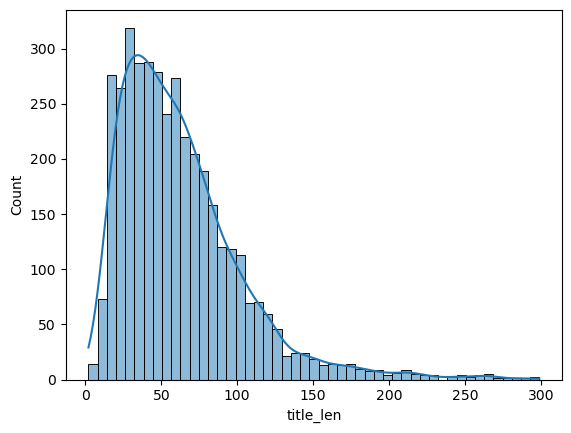

In [15]:
sns.histplot(data=df, x="title_len", kde=True);

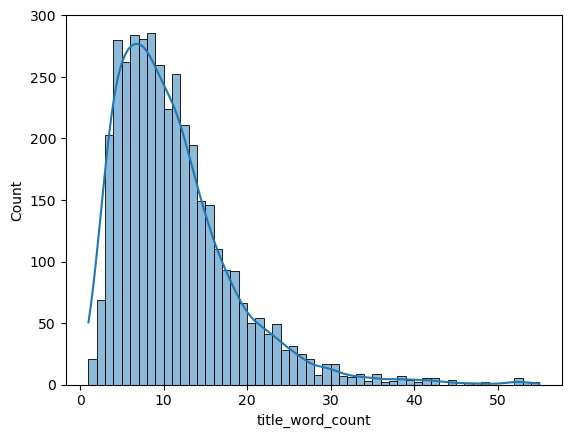

In [16]:
sns.histplot(data=df, x="title_word_count", kde=True);

In [17]:
df.describe(exclude=[object])  

,label,title_word_count,title_len,post_word_count,post_len
count,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000
mean,0.490779,11.070697,62.437244,44.424949,254.692111
std,0.499979,7.165345,40.521917,127.124875,755.843437
min,0.000000,1.000000,2.000000,0.000000,0.000000
25%,0.000000,6.000000,33.000000,0.000000,0.000000
50%,0.000000,10.000000,54.000000,0.000000,0.000000
75%,1.000000,14.000000,81.000000,37.000000,191.000000
max,1.000000,55.000000,299.000000,2400.000000,14044.000000


In [18]:
df['title_len'].skew()

1.6930677133748218

In [19]:
df['title_word_count'].skew()

1.7314477227455667

The skew of `title_len` and `title_word_count` is very similar.  
This is to be expected as they are describing the different aspects of the same feature.

In [20]:
user_list = list(df['user'].unique())
len(df['user'].unique())

2750

In [21]:
# This is not being used anywhere.
# This is just to gather and store all information 
# into a dictionary, with user as the key.
# information includes number of post for
# ns, ps and total
user_behave_dict = {}
label_list = ['ns', 'ps']
for user in user_list:
    user_post_list = []
    counter = 0
    for idx, label in enumerate(label_list):
        df_temp = df.loc[(df['user']==user) & (df['label'] == idx)]
        post_num = len(df_temp)
        counter = counter+post_num
        user_post_list.append({label+'_post_num':post_num})
    user_post_list.append({'total_post_num':counter})
    user_behave_dict[user] = user_post_list

In [22]:
# this is a slightly better way of building what I want
ns_post_list = []    
for user in user_list:
    df_temp = df.loc[(df['user']==user) & (df['label'] == 1)]
    post_num = df_temp.shape[0]
    ns_post_list.append(post_num)

In [23]:
ps_post_list = []    
for user in user_list:
    df_temp = df.loc[(df['user']==user) & (df['label'] == 0)]
    post_num = df_temp.shape[0]
    ps_post_list.append(post_num)

In [24]:
user_dict = {'user_name':user_list,
             'ns_posts':ns_post_list,
             'ps_posts':ps_post_list}
user_posts_df = pd.DataFrame(user_dict)
user_posts_df['total_posts'] = user_posts_df['ns_posts']+user_posts_df['ps_posts']

In [25]:
user_posts_df.head()

,user_name,ns_posts,ps_posts,total_posts
0,1338h4x,17,0,17
1,tale-wind,24,0,24
2,Focusboy50,1,0,1
3,Nas160,3,0,3
4,blubberpuppers,13,0,13


In [26]:
# Make everything into a function
def make_user_posts_df(df, lablel_list, search='user', on='label'):
    '''This function makes a dataframe counting appearence of search item based on label
    args:
        df: the dataframe to search through
        label_list: name of the labels in a list
        search: colmun of unique entires for the original dataframe to search on
        on: colmun of original data frame which labels the entires as 0, 1, 2...
    out:
        final_df: dataframe that contains the occurance of each unique entry based on label
    '''
    # make unique list of search object
    unique_list = list(df[search].unique())
    unique_dict = {search:unique_list}
    # run through each label
    for i, label in enumerate(label_list):
        temp_list = []
        # run through unique list of search object
        for unique_val in unique_list:
            df_temp = df.loc[(df[search]==unique_val) & (df[on] == i)]
            post_num = df_temp.shape[0]
            temp_list.append(post_num)
        # store the unique list to the dictionary
        unique_dict[label] = temp_list
    # convert the dictionary to dataframe
    final_df = pd.DataFrame(unique_dict)
    # sum it all up
    final_df['sum'] = final_df[label_list[0]]
    for label in label_list[1:]:
        final_df['sum'] = final_df['sum'] + final_df[label]
    return final_df

In [27]:
make_user_posts_df(df, ['ns, ps'])

,user,ns,ps,sum
0,1338h4x,0,17,17
1,tale-wind,0,24,24
2,Focusboy50,0,1,1
3,Nas160,0,3,3
4,blubberpuppers,0,13,13
...,...,...,...,...
2745,b151,1,0,1
2746,ipoopup,1,0,1
2747,gracekk24PL,1,0,1
2748,MrRoboto12345,1,0,1


In [28]:
user_posts_df.loc[(user_posts_df['ps_posts'] != 0) & (user_posts_df['ns_posts'] != 0)]

,user_name,ns_posts,ps_posts,total_posts
120,MoonieSarito,2,1,3
284,Tail_sb,1,1,2
453,aperson7780,1,1,2
507,Frocharocha,42,1,43
561,ddudegames,1,1,2
593,MarineKingPrime_,1,1,2
596,Ragnara92,1,1,2
795,schuey_08,2,1,3
835,Filmfan345,1,1,2


Out of the 3904 posts collected, only 2750 users are unique.  
This means that there are many users who posted more than 1 post.  
They are probably the very active users.  
To my surprise, the number of users who posts on both `r/nintendo` and `r/playstation` is very few...  
There are only 9 users out of 2750 unique users in total...  
Does this mean that the users who use `r/nintendo` usually will not use `r/playstation`?  
Anyways, this should be a good news for me, as this means that the wordings should be rather far apart in the vector space.  

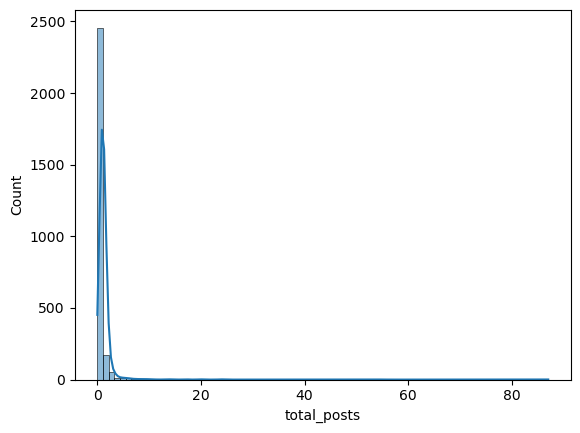

In [29]:
sns.histplot(data=user_posts_df, x="total_posts", kde=True, bins=80);

Majority of the users only post 1 single post in the data collected.

In [30]:
user_posts_df.sort_values(by='total_posts', ascending=False).head(10)

,user_name,ns_posts,ps_posts,total_posts
31,Riomegon,87,0,87
9,RoboticOperatingBudd,82,0,82
46,razorbeamz,55,0,55
507,Frocharocha,42,1,43
131,Amiibofan101,35,0,35
1,tale-wind,24,0,24
18,Asad_Farooqui,24,0,24
58,LinkWink,20,0,20
537,harushiga,20,0,20
0,1338h4x,17,0,17


Seems that `r/nintendo` users topped the chart for posting the most posts?  
Maybe the playstation users are restricted in the number of posts they can make, or simply because playstation have no activity, since Nintendo have the largest number of exclusive games.

## Prelim model

This section, a very basic model will be built to facilitate EDA.

In [31]:
nltk_stop_words = set(stopwords.words('english'))

In [32]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(nltk_stop_words)

In [33]:
cvec = CountVectorizer(stop_words=my_stop_words, min_df=5)

In [34]:
cvec.fit(df['title'])

CountVectorizer(min_df=5,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'ain',
                                      'all', 'almost', 'alone', 'along',
                                      'already', 'also', 'although', 'always',
                                      'am', 'among', 'amongst', 'amoungst',
                                      'amount', 'an', 'and', 'another', 'any',
                                      'anyhow', 'anyone', 'anything', 'anyway', ...}))

In [35]:
X_train = cvec.transform(df['title'])

In [36]:
X_train.shape

(3904, 1000)

## Does the curse of dimensionality apply here?

In [37]:
word_vector = X_train.toarray()

In [38]:
feature_name = cvec.get_feature_names_out()

In [39]:
count_vectorised_df = pd.DataFrame(data=word_vector, columns=feature_name)

In [40]:
count_vectorised_df.shape

(3904, 1000)

In [41]:
count_list = count_vectorised_df.sum()

In [42]:
count_df = pd.DataFrame(data=count_list, columns=['count'])

In [43]:
count_df.sort_values('count', ascending = True).tail(15)

,count
history,100
like,102
years,103
got,111
ps4,124
day,148
playstation,166
super,196
new,235
games,276


Key give away words present here are as follows:  
nintendo: nintendo, switch, mario, super (commonly associated with mario)  
playstation: ps5, playstation, ps4  

<AxesSubplot: >

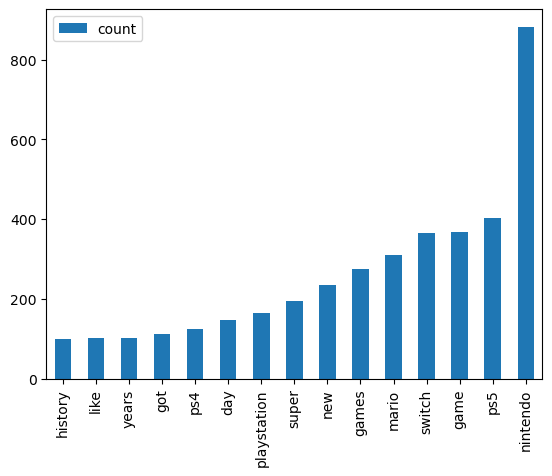

In [44]:
count_df.sort_values('count', ascending = True).tail(15).plot(kind='bar')

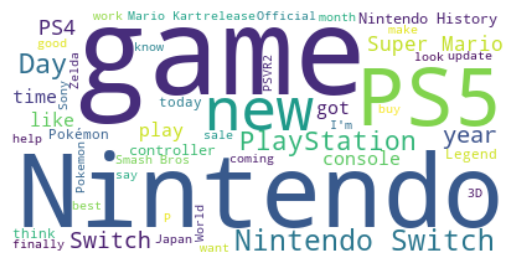

In [45]:
# Start with one review:
text = " ".join(title for title in df['title'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=my_stop_words, background_color="white", max_words=50).generate(text)

# Display the generated image:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
# Save the image in the img folder:
wordcloud.to_file("../img/ntd_ps_1st.png");

<AxesSubplot: xlabel='count', ylabel='Count'>

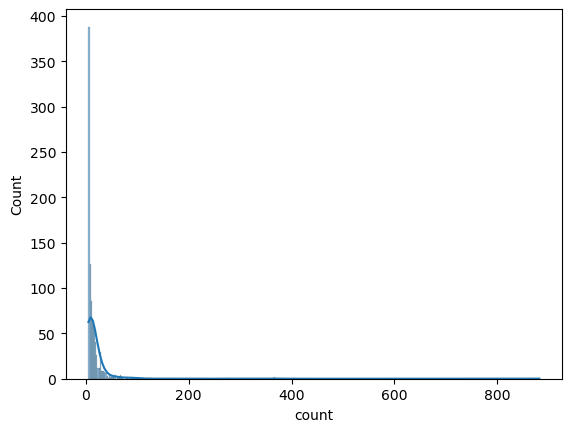

In [47]:
sns.histplot(data=count_df, x='count', kde=True)

The post data is obviously skewed.   
This means that if Navive bayes were to be used, the Guassian Naive Bayes can not be used.  
The correct model to use here should be the `Multinomial Naive Bayes`.  
Also, a check with scikit-learn documentation confirms my theory.  

In [48]:
word_count_sum = X_train.sum(axis=0)
word_counts_array = word_count_sum.ravel()

In [49]:
# test for normality
stat, p = shapiro(word_counts_array)
print('Shapiro-Wilk test statistic:', stat)
print('p-value:', p)

Shapiro-Wilk test statistic: 0.24349123239517212
p-value: 0.0


Previously, the entire `df['title']` is used in count vectoriser.  
It was done for the purpose of analysis.  
Now I will split my data set into train and test, then vectorise them using TFIDF.  
After which, a preliminary model will be developed for the purpose of further analysis.  

In [69]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)

In [51]:
vectorizer = TfidfVectorizer(stop_words=my_stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)

In [52]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [53]:
X_test_tfidf = vectorizer.transform(X_test)

In [54]:
y_pred = clf.predict(X_test_tfidf)

In [55]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.9142125480153649
Confusion matrix:
 [[344  38]
 [ 29 370]]


In [56]:
y_pred_train = clf.predict(X_train_tfidf)

In [57]:
print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train, y_pred_train))

Accuracy: 0.9817483189241114
Confusion matrix:
 [[1583   23]
 [  34 1483]]


Make the steps taken above into a pipeline.  
This will be more user friendly!  

In [77]:
# make a pipeline ==> make my own class? 
steps_taken = [
                ('tfid', TfidfVectorizer(stop_words=my_stop_words)),
                ('Multinomial_Naive_Bayes', MultinomialNB())
                ]
tfidf_pipeline = Pipeline(steps_taken)

In [81]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'ain', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
                                                       'anything', 'anyway', ...}))),
                ('Multinomial_Naive_Bayes', MultinomialNB())])

In [83]:
y_pred_pipe = tfidf_pipeline.predict(X_test)

In [84]:
print('Accuracy:', accuracy_score(y_test, y_pred_pipe))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_pipe))

Accuracy: 0.9142125480153649
Confusion matrix:
 [[344  38]
 [ 29 370]]


Write a `print_confusion_matrix()` function.  

In [58]:
def print_confusion_matrix(y_actual, y_pred):
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

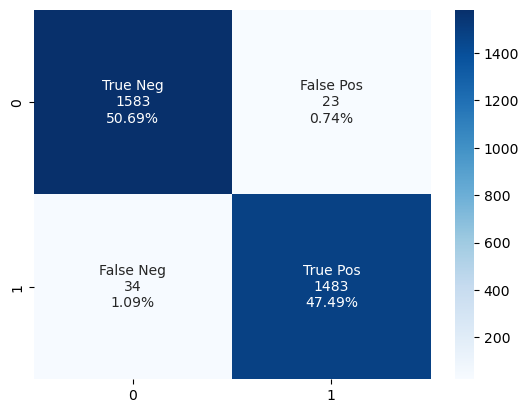

In [59]:
print_confusion_matrix(y_actual=y_train, y_pred=y_pred_train)

In [60]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The recall of this inference is: {rec}")
    print(f"The precision of this inference is: {pre}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [61]:
metrics_for_model(y_test, y_pred);

The recall of this inference is: 0.9273182957393483
The precision of this inference is: 0.9068627450980392
The f1 score for this inference is: 0.9169764560099132


With all the components ready, I can make this into a class object with various mathods to simple uses!

In [99]:
class NBModel(object):
    '''A class to create a quick and dirty preliminary Multinomial NB Model
    '''
    def __init__(self, df, stop_words):
        self.df = df
        self.stop_words = stop_words
    
    def split_data(self, test_size=0.2, random_state=42):
        '''splits the data in df
        args:
            test_size: percentage of data used for testing. They are not fed into training. default=0.2
            random_state: random_state to ensure same anser. default = 42, cus 42 is the answer to everything. I just dunno the question Xp
        '''
        X_train, X_test, y_train, y_test = train_test_split(self.df['title'], self.df['label'], test_size=test_size, random_state=random_state)
        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_train = y_train
    
    def training(self, vectorizer='tfidf'):
        '''train model with portion of data used for training
        args:
            vectorizer: what method to use to vectorise the words. 
                        availabe methods {'tfidf','cvec'}
                        default = 'tfidf'
        '''
        if vectorizer == 'tfidf':
            steps_taken = [
                    ('tfid', TfidfVectorizer(stop_words=self.stop_words)),
                    ('Multinomial_Naive_Bayes', MultinomialNB())
                    ]
        elif vectorizer == 'cvec':
            steps_taken = [
                    ('tfid', CountVectorizer(stop_words=self.stop_words)),
                    ('Multinomial_Naive_Bayes', MultinomialNB())
                    ]
        else:
            print('No such vectoriser included! Defaulting to TFIDF.')
            steps_taken = [
                    ('tfid', TfidfVectorizer(stop_words=self.stop_words)),
                    ('Multinomial_Naive_Bayes', MultinomialNB())
                    ]            
        self.nb_pipeline = Pipeline(steps_taken)
        
    def fitting(self):
        '''Fit the model and create a trained/ fitted model
        '''
        self.fitted_model = self.nb_pipeline.fit(self.X_train, self.y_train)
    
    def make_prediction(self, X=None):
        '''Make prediction using datas
        args:
            X: df colmun of data to be predicted, in same format as df
        '''
        if X == None:
            y_pred = self.fitted_model.predict(self.X_test)
        else:
            y_pred = self.fitted_model.predict(X)
        self.y_pred = y_pred
    
    def confusion_matric(self):
        '''Make a confusion matrics with self.y_test and self.y_pred
        args:
            y_actual: actual label of y
            y_pred: predicted lable of y
        '''
        self.cf_matrix = confusion_matrix(self.y_test, self.y_pred)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        self.cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             self.cf_matrix.flatten()/np.sum(self.cf_matrix)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(self.cf_matrix, annot=labels, fmt='', cmap='Blues')
        
    def other_scores(self):
        '''Find other socres like recall, precision and f1
        '''
        try: 
            tn, fp, fn, tp = self.cf_matrix.ravel()
        except Exception as e:
            print(e)
            print("create cf_matrix now...")
            self.confusion_matric()
            print("done, retry...")
            tn, fp, fn, tp = self.cf_matrix.ravel()
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1 = 2*(pre*rec)/(pre+rec)
        print(f"The recall of this inference is: {rec}")
        print(f"The precision of this inference is: {pre}")
        print(f"The f1 score for this inference is: {f1}")
        return pre, rec, f1

'NBModel' object has no attribute 'cf_matrix'
create cf_matrix now...
done, retry...
The recall of this inference is: 0.9273182957393483
The precision of this inference is: 0.9068627450980392
The f1 score for this inference is: 0.9169764560099132


(0.9068627450980392, 0.9273182957393483, 0.9169764560099132)

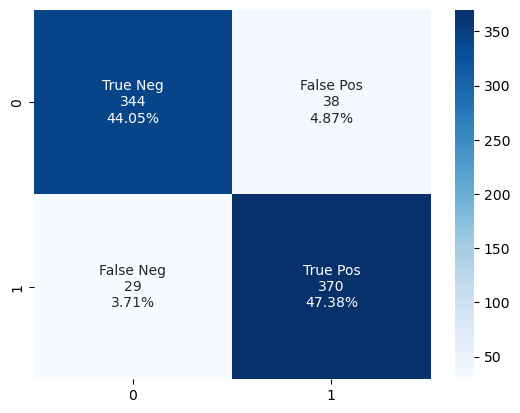

In [100]:
nb_model = NBModel(df, my_stop_words)
nb_model.split_data()
nb_model.training()
nb_model.fitting()
nb_model.make_prediction()
nb_model.other_scores()

## Further EDA

Now, let us test what are some of the words from this model.

In [75]:
whatever = pd.DataFrame({'title': ['game', 'nintendo', 'playstaion', 'haha', 'fun', 'graphics', 'mario', 'spiderman', 'meh']})

In [76]:
whatever

,title
0,game
1,nintendo
2,playstaion
3,haha
4,fun
5,graphics
6,mario
7,spiderman
8,meh


In [64]:
X_test_ana = vectorizer.transform(whatever['title'])

In [65]:
clf.predict(X_test_ana)

array([1, 1, 0, 0, 1, 0, 1, 0])

games are from nintendo and so is fun!  
but nintendo lacks graphics =(

In [66]:
# perform cross-validation and get the mean score
cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=5)
mean_cv_score = cv_scores.mean()

In [67]:
cv_scores

array([0.9184    , 0.9408    , 0.9296    , 0.91666667, 0.92628205])

In [68]:
mean_cv_score

0.9263497435897436